In [61]:
# Import high level Keras API for tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import library for querying for GPU information
from tensorflow.python.client import device_lib

If using Google colab, be sure to enable hardware acceleration by following the instructions at https://colab.research.google.com/notebooks/gpu.ipynb

In [62]:
# Make sure that we are using GPUs for now. If we are not, then we should abort.
gpus = tf.config.list_physical_devices('GPU')
assert(len(gpus) > 0)

# TODO #6: It would be good to query for information about the GPU here so that
# we can make decisions which allow the code to be portable to devices with
# varying amounts of resources.
devices_info = device_lib.list_local_devices()
gpus_info = [device for device in devices_info if "GPU" in device.name]

Next we will define our standard implementation of PPO. For a good overview of how PPO works, there is an excellent resource at https://www.youtube.com/watch?v=5P7I-xPq8u8&t=1s&ab_channel=ArxivInsights

The pseudocode from the paper is below:

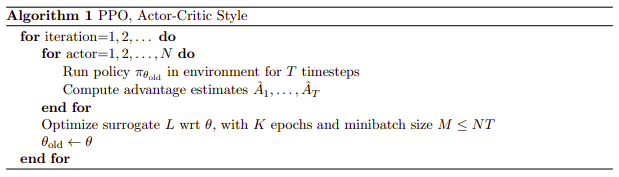

We start by creating a an Actor Critic model to build around. The tensorflow documentation has an implementation which has shared hidden layers, allowing for less computation.

https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

In [63]:
# This code is basically entirely from the tensorflow tutorial

class SimpleActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(self, num_actions, num_hidden_units):
    """Initialize."""
    super().__init__()

    self.common1 = layers.Dense(num_hidden_units, activation="relu")
    self.common2 = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs):
    x1 = self.common1(inputs)
    x2 = self.common2(x1)
    return self.actor(x2), self.critic(x2)

Now we have our Actor Critic model, but we don't actually need the value function for PPO... we need the advantage function. The advantage function is tracking the *advantage* of taking one action over others in a particular state. This is simply the Q value of that particular state action pair subtracting out the value of being in that state: $A^{\pi}(s_t,a_t) = Q^{\pi}(s_t,a_t)-V^{\pi}(s_t)$

Our actor critic model is already giving us an estimate of the value function $\hat{V}^{\pi}(s_t)$, so now we need to try to find the value of $Q^{\pi}(s_t,a_t)$ and we will be all set! Well, we are not tracking that.

Fortunately, there is an alternative estimator for the advantage function known as the generalized advantage estimation (GAE).  There is an explanation of this function over at https://jonathan-hui.medium.com/rl-policy-gradients-explained-advanced-topic-20c2b81a9a8b, but basically this estimator takes the form $\hat{A}^{\pi}_n(s_t,a_t)=\sum^{t+n-1}_{t'=t}\gamma^{t'-t}r(s_{t'},a_{t'})-\hat{V}^{\pi}(s_t)+\gamma^n\hat{V}^{\pi}(s_{t+n})$. In this function, $n$ is the n step lookahead and $t$ is the current time step. What we are essentially doing is looking at the expected n-step return for an epsidoe, subtracting the value of the current state, and adding in the discounted value of the state n steps into the future. This is intuitively similar to our previous definition of the advantage function using the Q value, as it takes a set of real state action pairs, calculates the actual values for the epsiode, and uses the estimate of the resulting state. This is a high-variance estimate of the Q value, but the Q value is what we were looking for!

Going back to the n-step return, n is a free parameter that lets us balance between pure TD learning (where $n=0$) and monte carlo runs (where $n$ is the full episode). We don't have to specifically pick one of those two, but in our case, one simple approach computationally is to roll out entire episodes, using monte carlo runs. By doing this, the term $\gamma^n\hat{V}^{\pi}(s_{t+n})$ goes to 0 as the value of the terminal state is 0. This leaves us with an advantage estimate of $\hat{A}^{\pi}_n(s_t,a_t)=\sum^{\infty}_{i}\gamma^{i}r_{t+i}-\hat{V}^{\pi}(s_t)$. It is also worth noting that $\sum^{\infty}_{i}\gamma^{i}r_{t+i}$ in our case will not go to infinity, but rather it will terminate at the end of each episode, which will terminate at some time step $T$. This means that we are working with $\sum^{T}_{i}\gamma^{i}r_{t+i}$ is equal to our episode return starting at timestep t, or $G_t$. This ultimately leaves us with an advantage estimate of $\hat{A}^{\pi}_n(s_t,a_t)=G_t-\hat{V}^{\pi}(s_t)$. This is something we can work with, as we will have episodic roll-outs to compute the expceted return $G_t$ for each timestep and our actor critic model will be returning an estimate of the value $V(s_t)$ at each timestep! We now have a mechanism to calculate an estimate under our policy for the advantage function at each time step for an episode.

Once again, there is an existing implementation in the tensorflow Actor Critic example, so we will draw from that for our implementation.

In [64]:
def get_expected_returns(values, rewards, final_value, dones, gamma, lambda_):
  """Compute expected returns per timestep."""
  # Get the number of rewards to accumulate for the epsiode
  n = tf.shape(rewards)[0]

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array. This lets us iteratively accumulate
  # discount factor to avoid needing to raise the discount factor
  # to a power for each iteration. It also lets us calculate the
  # return for each timestep independently.
  #rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  nstep_return = 0
  returns = []

  # Initialize the sum to 0
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape

  # Iterate over all rewards in the episode in reverse order
  for t in tf.range(n-1, -1, -1):
    next_value = None
    if t == n - 1:
      next_value = tf.squeeze(final_value, 1)
    else:
      next_value = values[t + 1]

    nstep_return_delta = rewards[t] + gamma * next_value * dones[t] - values[t]
    nstep_return = nstep_return_delta + gamma * lambda_ * dones[t] * nstep_return
    returns.insert(0, nstep_return + values[t])
  
  # Convert the returns for each time step to a tensor
  returns = tf.expand_dims(returns, 0)
  #returns = tf.cast(returns[::-1], dtype=tf.float32)

  return returns

Next, we will need to define an implementation of our loss function. The loss function defined in the paper is as follows:

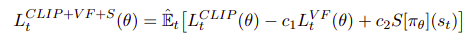

In layman's terms, this is basically saying to use a clipping objective, subtract off a scaled down loss of the critic (which in our case is taken from the advantage), and add in a scaled down bonus for an entropy term. We should cover each of these in detail.

$L^{CLIP}_t(\theta)=\hat{\mathbb{E}}_t[\min{(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta),1-\epsilon,1+\epsilon))}]$ where $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$.

This deserves its own deep dive. The term $r_t(\theta)$ is roughly measuring how a current policy deviates from a previous iteration from the policy. If the two policies are identical, then this value will be exactly 1. The more that the new policy deviates from the old policy, the more different these values will be.

The goal is to try and limit deviations from the previous policy to the current policy by trying to limit how large of a step gets taken when the policy change appears to be heading in the right direction. By clipping the loss function in this way, the gradient that gets backpropogated will be conservative if the step taken was in a good direction, but it need not be conservative if the step taken was in a very poor direction from what was present in the original policy. The end result is that the training process tends to be more stable in the policy space.

The next two terms in our overall loss function were $-c_1L^{VF}_t(\theta)+c_2S[\pi_\theta](s_t)$. The values $c_1,c_2$ are hyperparameters which control the contribution of the other two terms. The term $L^{VF}_t(\theta)$ is simply our critic loss, which can be implemented using some standard regression loss formula (the paper uses MSE) for our advantage estimate of $G_t-\hat{V}^{\pi}(s_t)$. The value $S[\pi_\theta](s_t)$ is an entropy bonus, where we are essentially trying to maximize the entropy of the distribution of actions for a given state. The generic formula for entropy is $-\sum p(x)\log(x)$ for some probability distribution $p(x)$. In this case, our distribution is the policy in a given state, or a sample at some time step of our actor output.

The below code is based once again on the Tensorflow actor critic example, but since this is for PPO, we start to diverge from their implementation.

In [65]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_ppo_loss(new_action_probs, actions, old_action_probs, values, advantages, returns, c1, c2, epsilon):
  """Computes the proximal policy loss."""

  # TODO: this should be optimized to reduce computation

  # The log of a product is the sum of the logs, so take the log of the
  # action probabilities, subtract what would have been the divisor from what
  # would have been the numerator, and then raise back up to the original
  # space. This has the same effect as dividing the two.
  new_action_log_probs = tf.math.log(new_action_probs)
  old_action_log_probs = tf.math.log(old_action_probs)

  # Calculate the entropy, which will be used to encourage exploration.
  # Entropy is calculated for each sample across its set of actions.
  entropy = tf.math.reduce_sum(new_action_probs * new_action_log_probs, axis=1) * -1
  entropy = tf.math.reduce_mean(entropy)

  # Calculate the value of R for the actions taken in our rollouts
  r = tf.math.exp(new_action_log_probs - old_action_log_probs)

  # Compute the clipped value of r to ensure that we are not too aggressive in
  # updates in policy space which we think are going in the right direction.
  clipped_r = tf.clip_by_value(r, 1 - epsilon, 1 + epsilon)
  actor_loss = tf.math.minimum(r, clipped_r) * advantages
  actor_loss = tf.math.reduce_mean(actor_loss)

  # We can use any loss function. Use huber loss, which is less sensitive to
  # outliers than RMSE and friends.
  # TODO: investigate if the order of the parameters matters for calculation
  # of the gradient given that the critic loss in the paper is negative
  #critic_loss = huber_loss(values, returns)
  critic_loss = huber_loss(values, returns)#tf.math.sqrt(tf.math.reduce_mean(tf.math.square(returns - values)))

  # Take the negative of our loss because the algorithm is written up for
  # ascent, but our optimizer is performing descent
  ppo_loss = -(actor_loss - c1 * critic_loss + c2 * entropy)

  return ppo_loss, actor_loss, critic_loss, entropy

We now have a loss function! We have our network for the forward and backward pass too. So we are ready to train, right? Well, first we are going to need to set up the pieces to get data to train on. Fortunately, the Tensorflow actor critic example is once again our friend, and a lot of the code can be lifted from there.

We now have a way to run episodes in a tensorflow-friendly way to gather data. This means that we are ready to start writing up a training loop. Some, but not all of this can come from the tensorflow actor critic example.

In [104]:
@tf.function
def train_minibatch(mb_states, mb_actions, mb_actions_idx, mb_action_probs, mb_advantages, mb_returns, model, optimizer, c1, c2, epsilon):
  """Runs a model training step."""

  with tf.GradientTape() as tape:
    # Predice the new action values
    new_action_logits, new_values = model(mb_states)

    # Calculate new action probabilities
    new_action_prob_dists = tf.nn.softmax(new_action_logits)

    # Get the action probabilities
    new_action_probs = tf.gather_nd(new_action_prob_dists, mb_action_idx)
    new_action_probs = tf.expand_dims(new_action_probs, 1)

    # Calculating loss values to update our network
    loss, L_a, L_c, S = compute_ppo_loss(new_action_probs, mb_actions, mb_action_probs, new_values, mb_advantages, mb_returns, c1, c2, epsilon)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  #optimizer.apply_gradients(
  #    (grad, var) 
  #    for (grad, var) in zip(grads, model.trainable_variables) 
  #    if grad is not None
  #)

  return loss, L_a, L_c, S

At long last, we are ready to set up an environment and try things out! Let's start out with a simple Cartpole environment to see how we do.

In [67]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -q git+https://github.com/tensorflow/docs 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


Finished step 499 with 4 episode rollouts and 4 training epochs: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s, episode_reward=[52.0, 100.0, 87.0, 44.0], max_running_reward=57.9, running_reward=57.3]


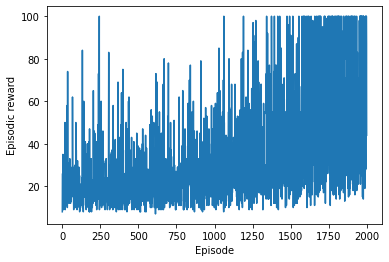

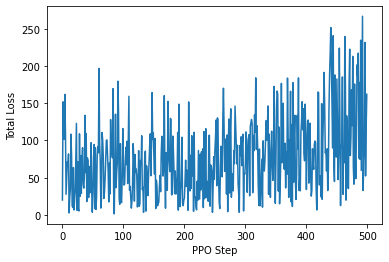

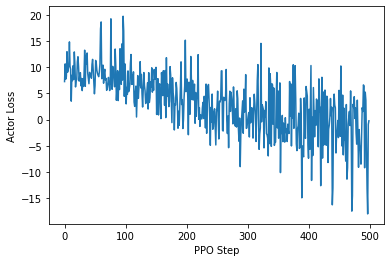

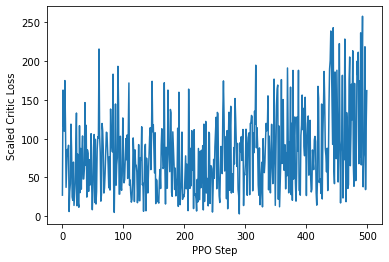

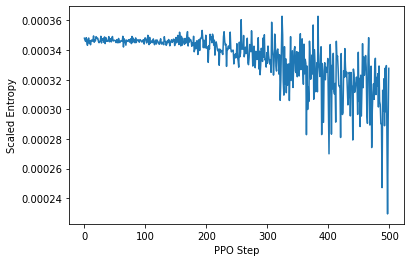


Unable to solve after 499 episodes. Average reward: 57.34


In [105]:
import collections
import gym
import numpy as np
import tqdm

from matplotlib import pyplot as plt

# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 12345
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

max_episodes = 2000
max_steps_per_episode = 100

# Cartpole-v1 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Learning rate for optimizer
_learning_rate = 3e-5

# Discount factor for future rewards
gamma = 0.99

# Generalized advantage estimate trade-off (between 0 and 1)
lambda_ = 0.97

# Loss function parameters
c1 = 0.5
c2 = 1e-3
epsilon = 0.1

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=_learning_rate)

num_actions = env.action_space.n 
num_hidden_units = 128

model = SimpleActorCritic(num_actions, num_hidden_units)

gather_episodes = 4
num_epochs = 4

# Make sure that the number of training epochs is smaller
# than the number of time steps gathered. Since we don't have an actual
# number of timesteps gathered, just make a conservative estimate of 5 steps
# per episode
assert(num_epochs <= (gather_episodes * max_steps_per_episode))

# FIXME: make this arch dependent
minibatch_size = 32

running_reward = 0
max_running_reward = 0
episode_rewards = []

total_losses = []
actor_losses = []
critic_losses = []
entropy_terms = []

step = 0


with tqdm.trange(max_episodes // gather_episodes) as steps:
  for step in steps:
    # Initialize training memory
    states = []
    actions = []
    action_probs = []
    values = []
    rewards = []
    dones = []

    # Gather data over some number of episodes
    for g in range(gather_episodes):
      
      state = env.reset()
      done = False

      episode_reward = 0
      epsiode_returns = []
      cur_ep_rewards = []
      cur_ep_dones = []

      for t in range(max_steps_per_episode):
        # Get a logits for aactions and predicted values
        action_logits, value = model(tf.expand_dims(state, 0))

        # Sample an action from the logits
        action = tf.random.categorical(action_logits, 1)[0, 0]

        # Track the distribution and grad the probability for the action we took
        action_prob_dist = tf.nn.softmax(action_logits)
        action_prob = action_prob_dist[:, action]

        # Take a step in the simulator
        state, reward, done, _ = env.step(action.numpy())

        # Keep track of values when the episode is not done by
        # 1 means the timestep counts
        done_f = float(1 - int(done))

        # Store it in memory
        states.append(state)
        actions.append(action)
        action_probs.append(action_prob)
        values.append(value)
        rewards.append(reward)
        dones.append(done_f)

        cur_ep_rewards.append(reward)
        cur_ep_dones.append(done_f)

        if done:
          break

      for reward, done in zip(cur_ep_rewards, cur_ep_dones):
        episode_reward += (reward * done)

      episode_rewards.append(episode_reward)
      running_reward = episode_reward*0.01 + running_reward*.99
      max_running_reward = max(running_reward, max_running_reward)

    # Convert the data to tensors
    states = tf.squeeze(tf.convert_to_tensor(states))
    actions = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(actions, dtype=tf.int32)), 1)
    action_probs = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(action_probs)), 1)
    values = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(values)), 1)
    rewards = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(rewards)), 1)
    dones = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(dones)), 1)

    _, final_value = model(tf.expand_dims(states[-1], 0))

    returns = get_expected_returns(values, rewards, final_value, dones, gamma, lambda_)
    returns = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(returns)), 1)
    advantages = returns - values

    #if step % 20 == 0:
      #print()
      #print("======================================")
      #print("Values:", tf.squeeze(values))
      #print("Rewards:", rewards)
      #print("Returns:", tf.squeeze(returns))

    # Convert tensors to a dataset with shuffled minibatches and a target number of epochs
    dataset = tf.data.Dataset.from_tensor_slices((states, actions, action_probs, advantages, returns))
    dataset = dataset.shuffle(max_steps_per_episode * minibatch_size).repeat(num_epochs).batch(minibatch_size)

    # Train over the gathered data for some number of iterations
    loss, L_a, L_c, S = None, None, None, None
    for batch in dataset:
      mb_states = batch[0]
      mb_actions = batch[1]
      mb_action_probs = batch[2]
      mb_advantages = batch[3]
      mb_returns = batch[4]
      mb_action_idx = tf.transpose(tf.stack([tf.range(mb_actions.shape[0]), tf.squeeze(mb_actions, 1)]))
      loss, L_a, L_c, S = train_minibatch(mb_states, mb_actions, mb_action_idx, mb_action_probs, mb_advantages, mb_returns, model, optimizer, c1, c2, epsilon)

    if loss:
      total_losses.append(loss)
      actor_losses.append(L_a)
      critic_losses.append(c1 * L_c)
      entropy_terms.append(c2 * S)


    steps.set_description(f'Finished step {step} with {gather_episodes} episode rollouts and {num_epochs} training epochs')
    steps.set_postfix(episode_reward=episode_rewards[-gather_episodes:], running_reward=running_reward, max_running_reward=max_running_reward)

    if running_reward > reward_threshold:  
        break

plt.plot(np.array(episode_rewards))
plt.xlabel("Episode")
plt.ylabel("Episodic reward")
plt.show()

plt.plot(np.array(total_losses))
plt.xlabel("PPO Step")
plt.ylabel("Total Loss")
plt.show()

plt.plot(np.array(actor_losses))
plt.xlabel("PPO Step")
plt.ylabel("Actor Loss")
plt.show()

plt.plot(np.array(critic_losses))
plt.xlabel("PPO Step")
plt.ylabel("Scaled Critic Loss")
plt.show()

plt.plot(np.array(entropy_terms))
plt.xlabel("PPO Step")
plt.ylabel("Scaled Entropy")
plt.show()

if running_reward > reward_threshold:
  print(f'\nSolved at episode {step}: average reward: {running_reward:.2f}!')
else:
  print(f'\nUnable to solve after {step} episodes. Average reward: {running_reward:.2f}')

In [106]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = env.reset()
  for i in range(1, max_steps + 1):
    action_probs, _ = model(tf.expand_dims(state, 0))
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(env, model, 5000)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


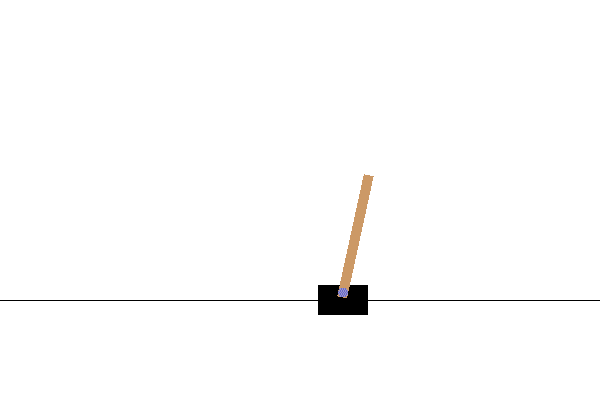

In [107]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)